## Environment setup

In [1]:
import glob, os
from functools import partial
import importlib

import tensorflow as tf


### Test data set preparation

In [2]:
import io_functions as io
importlib.reload(io)

from architecture_definitions import *

batchSize = 4096
nEpochs=1

testDataDir = "/scratch_cmsse/alibordi/data/test/"
testFileNames = glob.glob(testDataDir+'SingleMu_iPtX_Feb15_Unfiltered.tfrecord.gzip')

dataset = io.get_Classic_NN_dataset(batchSize, nEpochs, testFileNames, isTrain=False)

Reading data from files:
/scratch_cmsse/alibordi/data/test/SingleMu_iPtX_Feb15_Unfiltered.tfrecord.gzip


2023-04-20 08:59:54.137708: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-20 08:59:54.137727: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: fba800be2533
2023-04-20 08:59:54.137733: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: fba800be2533
2023-04-20 08:59:54.137780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 530.30.2
2023-04-20 08:59:54.137794: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 530.30.2
2023-04-20 08:59:54.137798: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 530.30.2
2023-04-20 08:59:54.137959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

### Load selected model version

In [3]:
import utility_functions as utils
importlib.reload(utils)

trainingSet = utils.getLatestModelPath(pattern="classic")
print("Using training set:",trainingSet)

job_dir = "results/"+trainingSet
os.makedirs(job_dir, exist_ok=True)

plot_dir = job_dir + "/figures"
os.makedirs(plot_dir, exist_ok=True)

checkpoint_path = "training/"+trainingSet

model = tf.keras.models.load_model(checkpoint_path, custom_objects=custom_objects)
model.summary()

Using training set: 2023_Apr_20_07_20_12_classic_128_64_32_1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pt_layer_1 (Dense)          (None, 128)               4864      
                                                                 
 pt_layer_2 (Dense)          (None, 64)                8256      
                                                                 
 pt_layer_3 (Dense)          (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 15,233
Trainable params: 15,233
Non-trainable params: 0
_________________________________________________________________


### Run the model and put the result into Pandas DataFrame

ptGenPtRec.shape (800, 800)
xedges.shape (801,)
yedges.shape (801,)


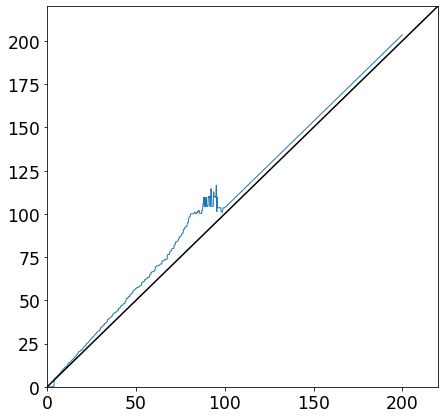

In [8]:
import utility_functions as utils
importlib.reload(utils)

import plotting_functions as plf
importlib.reload(plf)

modelAnswerPostProc = partial(utils.classicNNAnswerPostProc, output_type=output_type)

df = utils.df

for aBatch in dataset: 
    df = utils.fillPandasDataset(aBatch, df, model, modelAnswerPostProc)  
    
df = df[np.abs(df['GEN_eta'])<1.24]
df = df[np.abs(df['GEN_eta'])>0.83]   
    
ptToPtCalibNN, xedges = plf.ptRecalibration(df, plot_dir, oneOverPt, "NN_pt")
df["NN_pt_recalib"] = plf.ptRecalibrated(df["NN_pt"], ptToPtCalibNN, xedges)

### Make the plots

In [5]:
import plotting_functions as plf
importlib.reload(plf)

import utility_functions as utils
importlib.reload(utils)

fileName = job_dir+"/performance.txt"
utils.calculateLossFunctions(df, fileName)

plf.plotPtGenPtRec(df, plot_dir, oneOverPt)

for ptCut in plf.ptCuts :
    effStr, _, _ = plf.plotTurnOn(df, ptCut=ptCut, qualityCut = plf.qualityCut, plotDir=plot_dir)
    utils.appendStringToFile(effStr, fileName)
    print(effStr)

ratesStr = plf.plotRate(df, plf.qualityCut, plotDir=plot_dir)
print("rates NN", ratesStr)

utils.appendStringToFile(ratesStr, fileName)

MeanAbsoluteError NN 117.99598370521367


KeyError: 'NN_pt_recalib'

ptCut: 10 qualityCut: 12, eff@plateau: 0.98
ptCut: 15 qualityCut: 12, eff@plateau: 0.97
ptCut: 20 qualityCut: 12, eff@plateau: 0.96
ptCut: 25 qualityCut: 12, eff@plateau: 0.96
ptCut: 30 qualityCut: 12, eff@plateau: 0.95
ptCut: 40 qualityCut: 12, eff@plateau: 0.93
rates NN Rate @10 GeV:22687, @20 GeV: 4369


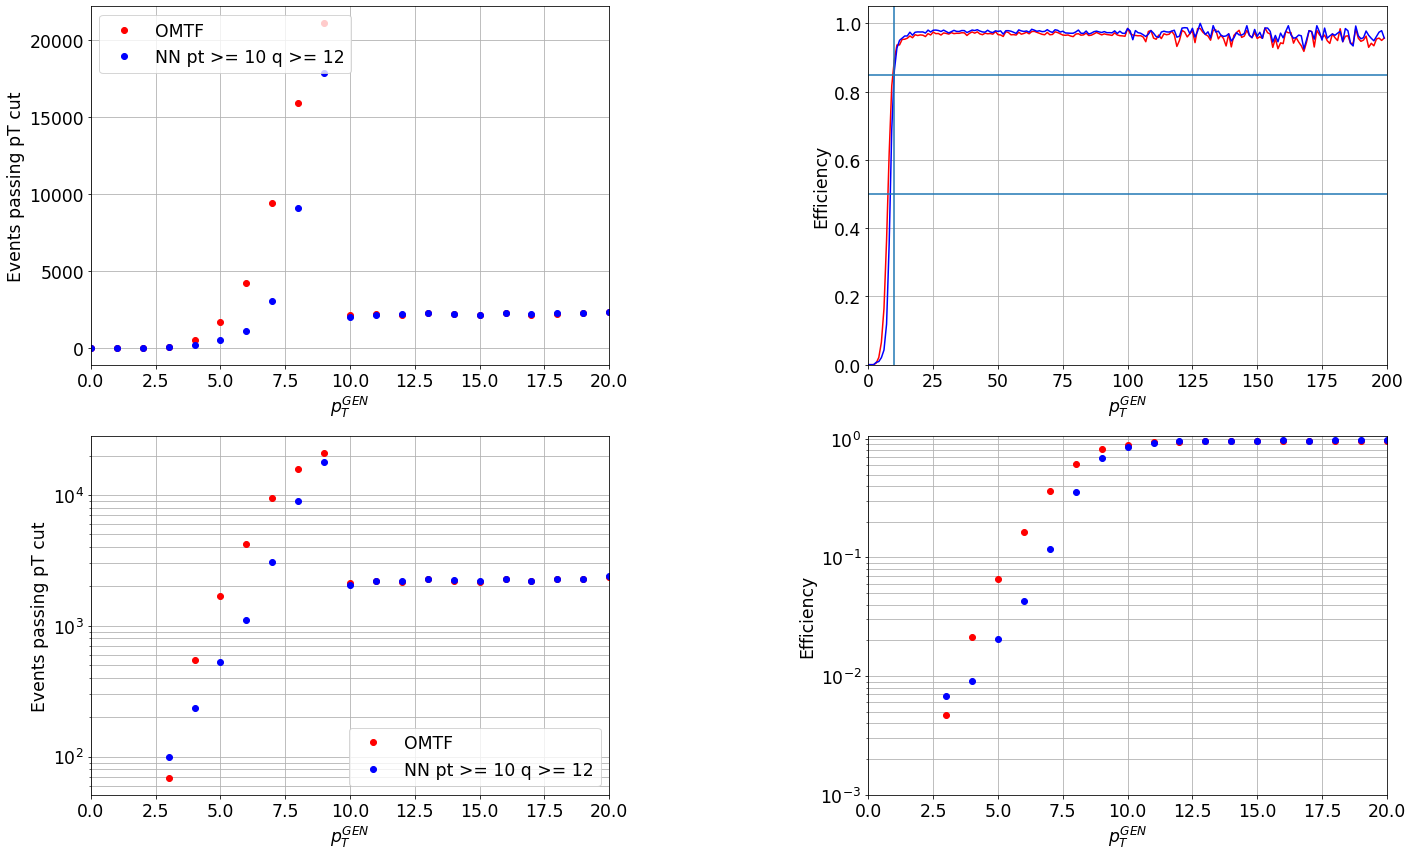

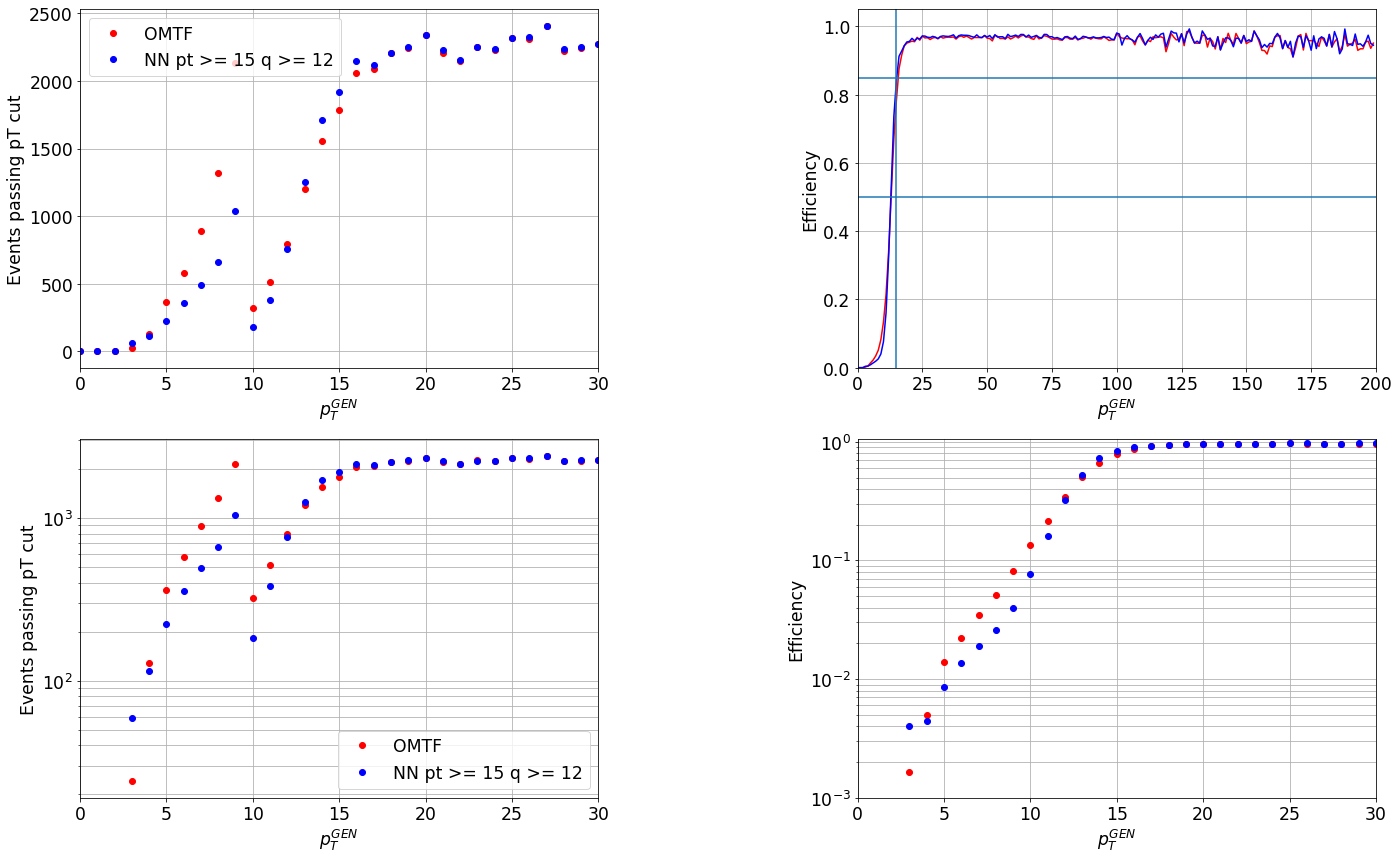

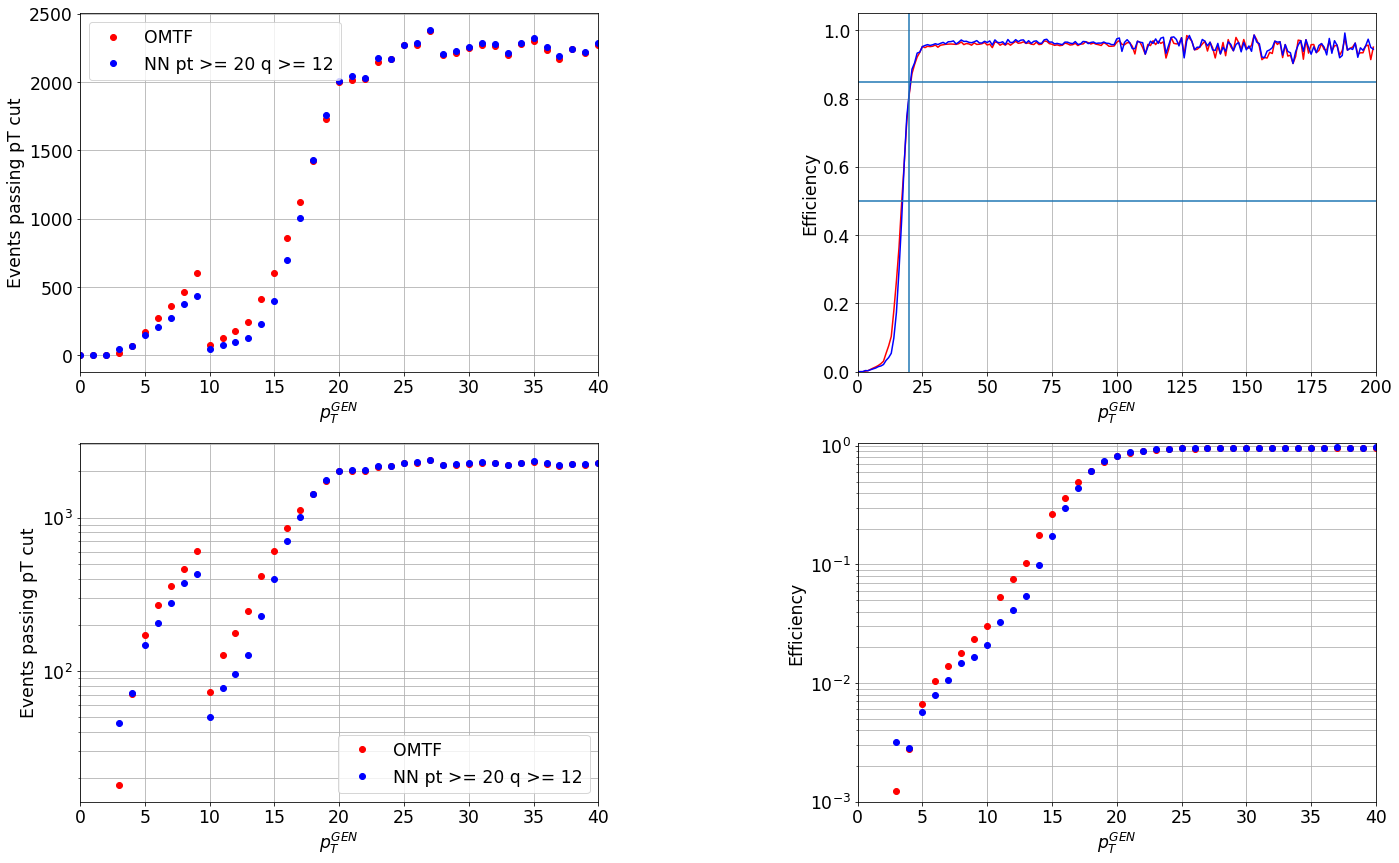

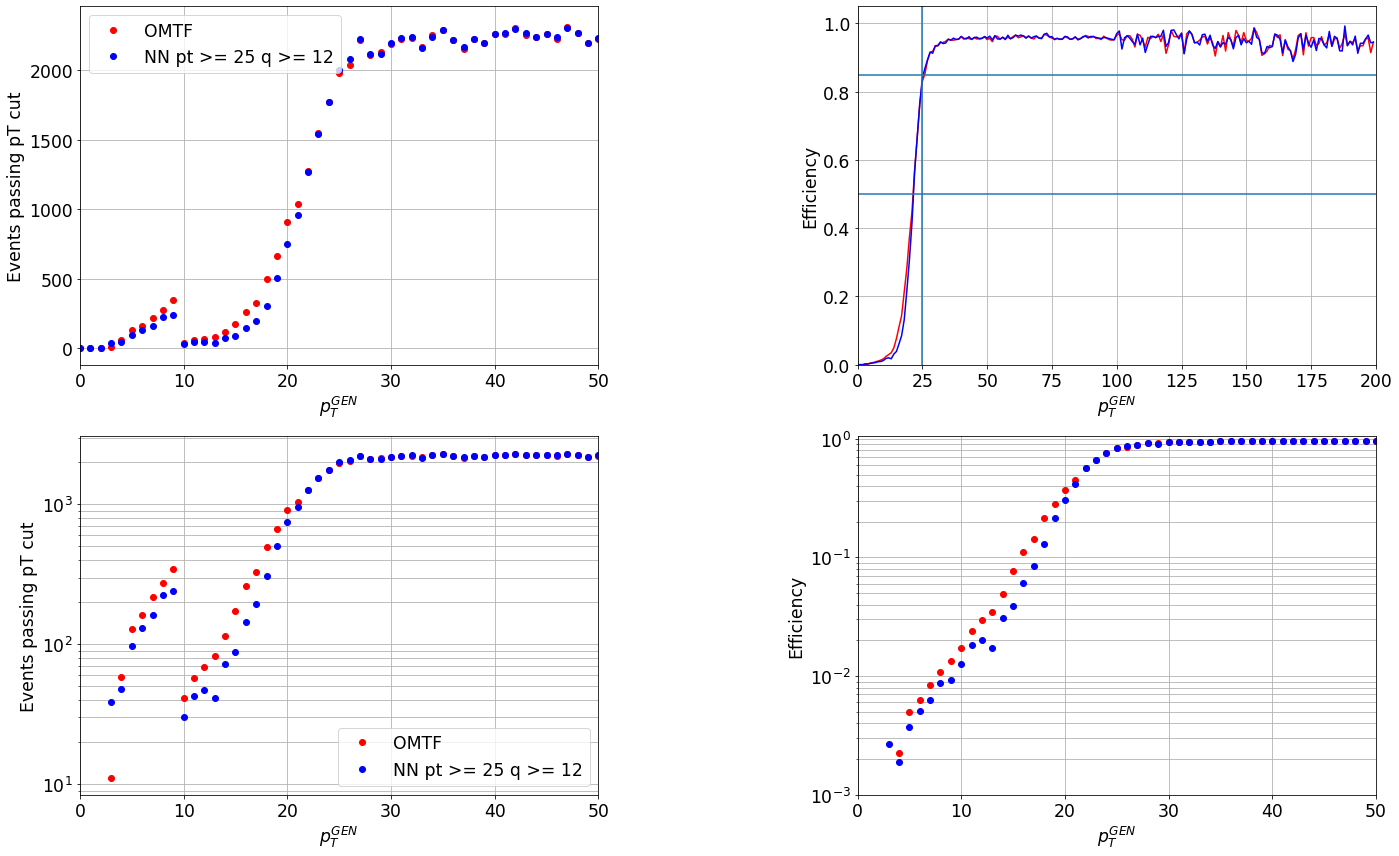

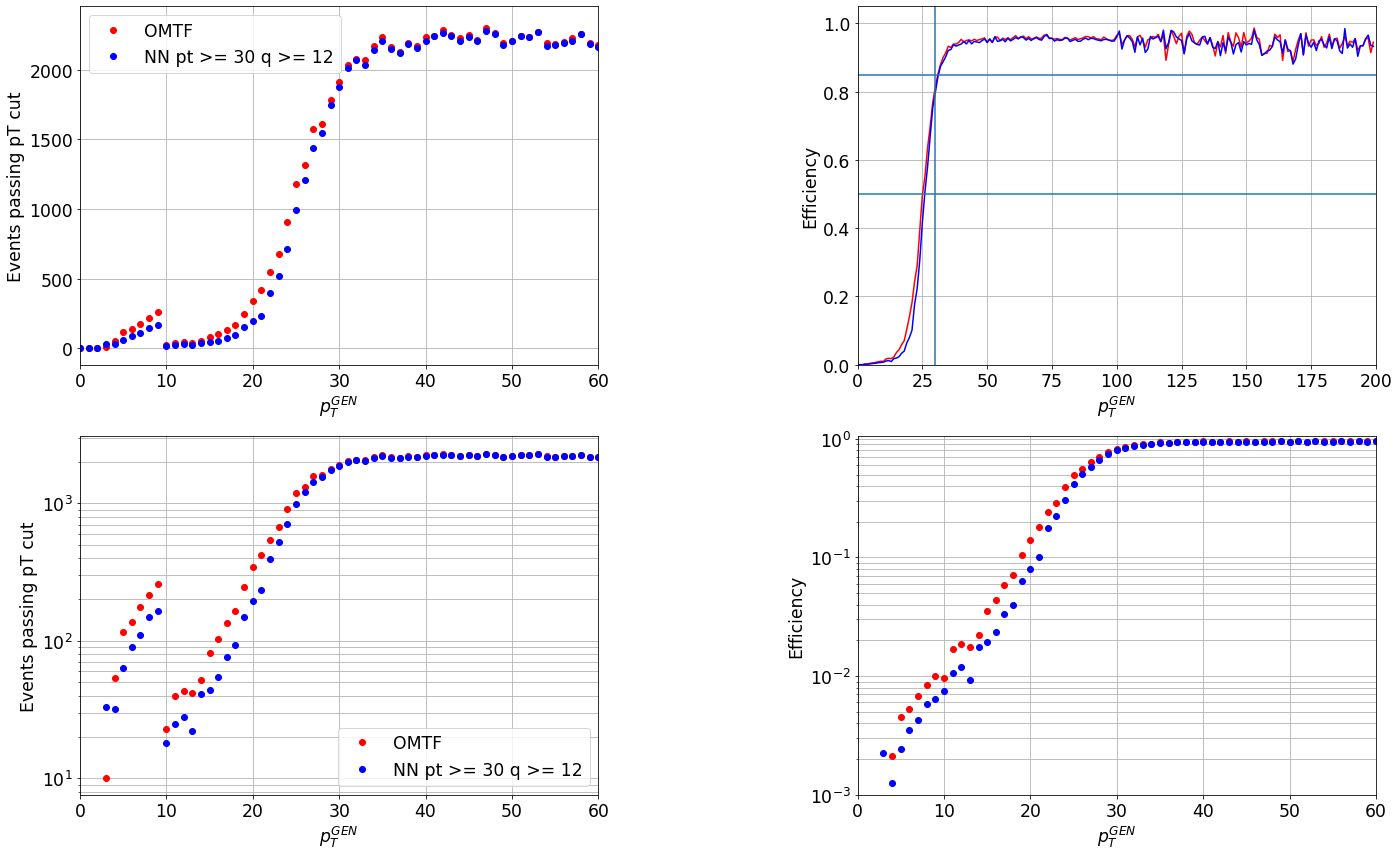

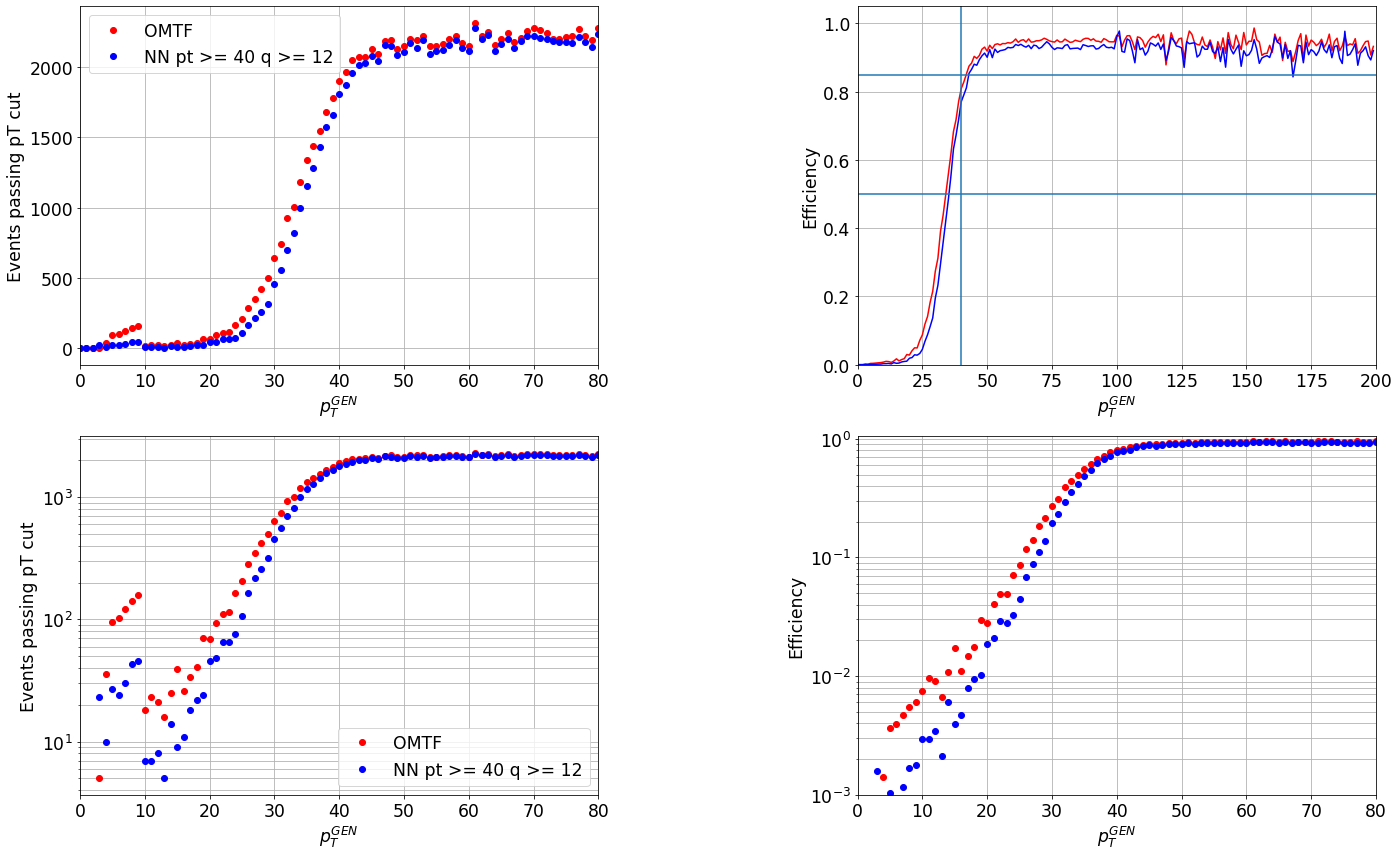

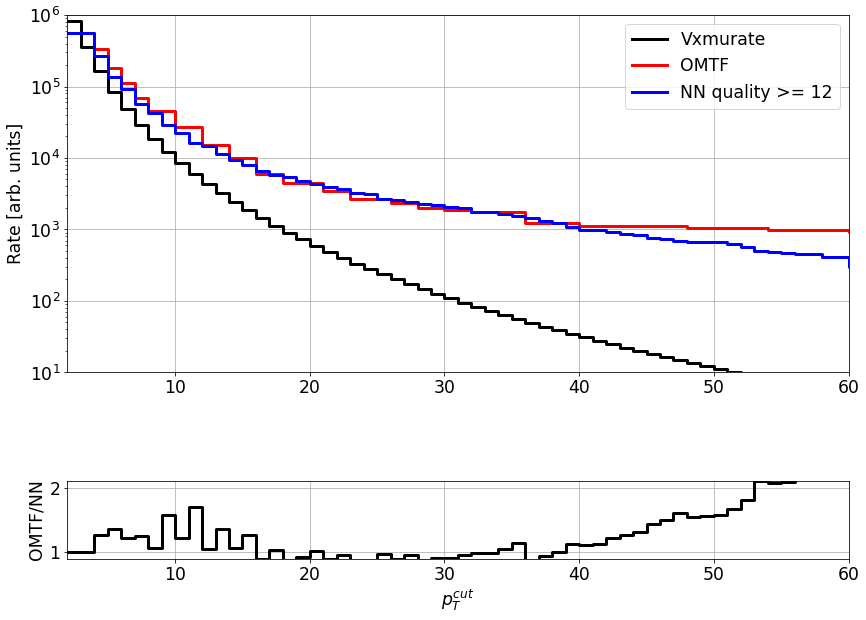

In [10]:
df["NN_pt"] = df["NN_pt_recalib"]

for ptCut in plf.ptCuts :
    effStr, _, _ = plf.plotTurnOn(df, ptCut=ptCut, qualityCut = plf.qualityCut, plotDir=plot_dir)
    utils.appendStringToFile(effStr, fileName)
    print(effStr)
    
ratesStr = plf.plotRate(df, plf.qualityCut, plotDir=plot_dir)
print("rates NN", ratesStr)   